# Test du Data Augmentation

In [10]:
from pathlib import Path
import sys, os
sys.path.append(os.path.abspath("../src"))

from cadot.data.loading import load_yolo_annotations
from cadot.data.augmentation import simple_augmentation, random_horizontal_flip, random_brightness, random_contrast
from cadot.data.loading import get_image_label_pairs
from PIL import Image
from pathlib import Path
import numpy as np
from cadot.utils.path import get_data_path
from cadot.data.visualisation import plot_image_with_annotations, yolo_boxes_to_annotations
from cadot.models.yolo import CADOT_CLASS_NAMES

In [11]:
pairs = get_image_label_pairs("train")
img_path, label_path = pairs[0]

img = Image.open(img_path)
annotations = load_yolo_annotations(label_path, img.width, img.height)

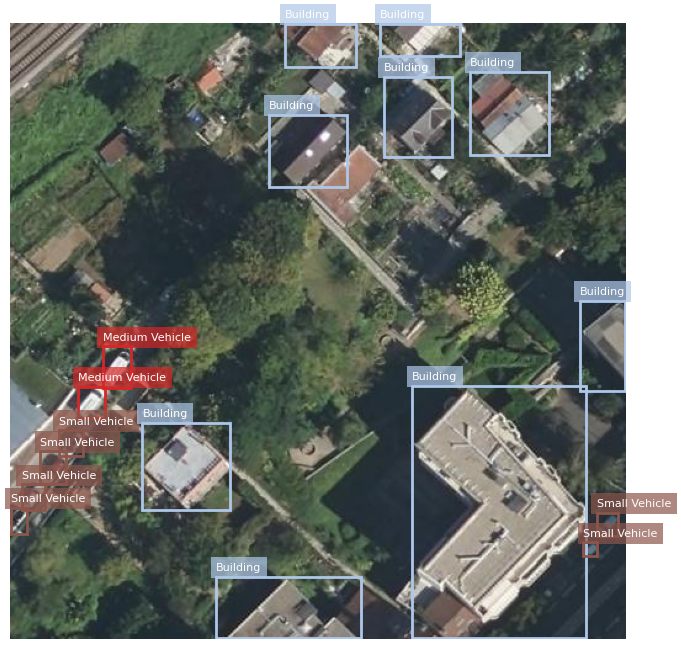

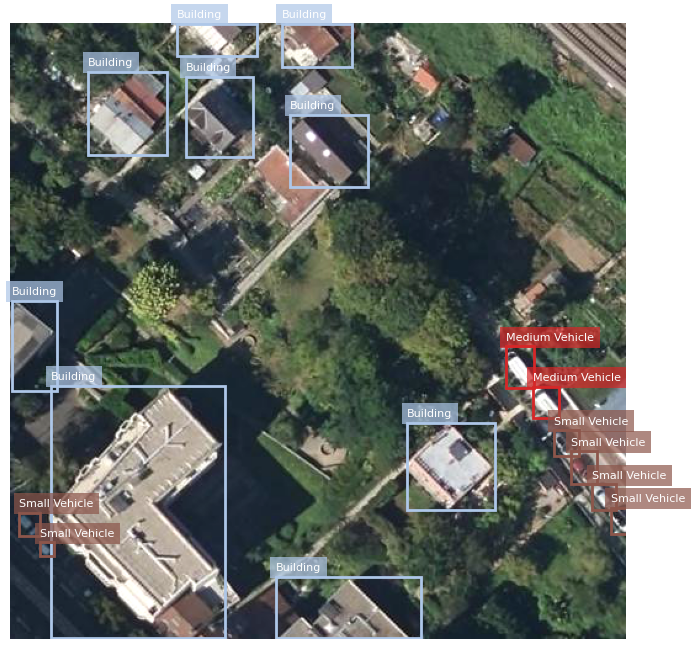

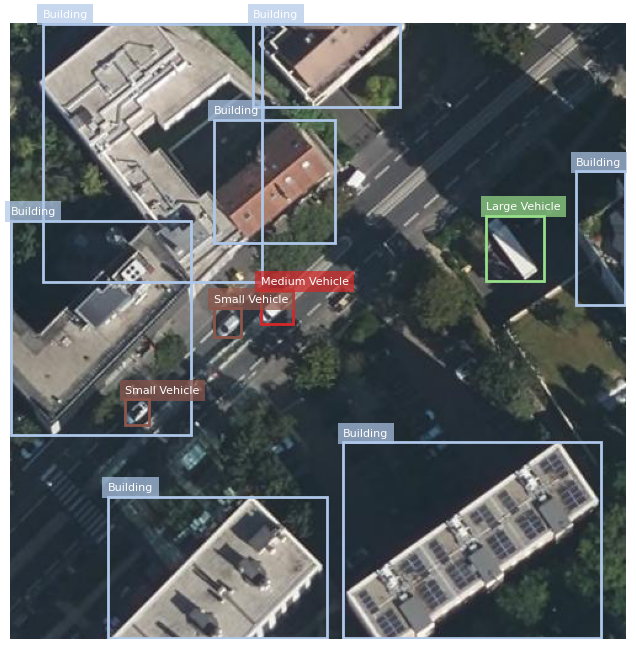

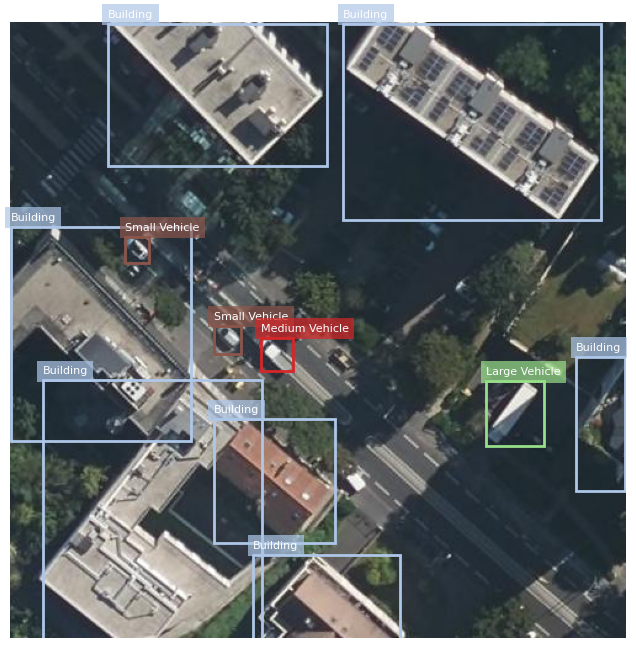

In [7]:
pairs = pairs[0:5]
plot_results = True
save_aug = False

for img_path, label_path in pairs:
    img = Image.open(img_path)
    annotations = load_yolo_annotations(label_path, img.width, img.height)
    img = img.convert("RGB")
    img_np = np.array(img)
    boxes = np.loadtxt(label_path, dtype=float).reshape(-1, 5)

    img_aug, boxes_aug = simple_augmentation(img_np, boxes)
    
    # Plot
    if plot_results:
        h, w = img_aug.shape[:2]
        annotations_aug = yolo_boxes_to_annotations(boxes_aug, w, h)
        plot_image_with_annotations(img, annotations, class_names=CADOT_CLASS_NAMES)
        plot_image_with_annotations(img_aug, annotations_aug, class_names=CADOT_CLASS_NAMES)

    # Save
    if save_aug:
        img_path = Path(img_path)
        label_path = Path(label_path)

        img_dir = img_path.parent
        label_dir = label_path.parent

        # Nouveau nom de base
        stem = img_path.stem 
        aug_img_path = img_dir / f"{stem}_aug.jpg"
        aug_label_path = label_dir / f"{stem}_aug.txt"

        # Sauvegarde de l'image augmentée
        Image.fromarray(img_aug).save(aug_img_path, quality=95)

        # Sauvegarde des labels au format YOLO (cls xc yc w h normalisés)
        boxes_to_save = np.asarray(boxes_aug, dtype=float).reshape(-1, 5)

        with open(aug_label_path, "w", encoding="utf-8") as f:
            for cls, xc, yc, w_norm, h_norm in boxes_to_save:
                f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w_norm:.6f} {h_norm:.6f}\n")

## Tests fonction par fonction

In [12]:
pairs = get_image_label_pairs("train")
img_path, label_path = pairs[0]

img = Image.open(img_path)
annotations = load_yolo_annotations(label_path, img.width, img.height)

img = img.convert("RGB")
img_np = np.array(img)

boxes = np.loadtxt(label_path, dtype=float).reshape(-1, 5)

In [26]:
import random
def random_gaussian_noise(img, boxes, p=0.5, std_max=40) -> tuple[np.ndarray, np.ndarray]:
    """
    Ajoute un bruit gaussien avec probabilité p.

    std : écart-type du bruit (en niveaux de gris, sur l'échelle [0, 255]).
    """
    if random.random() > p:
        return img, boxes

    # randomisation de la variance du bruit pour plus d'aléatoire
    std = random.uniform(5, std_max) # -> 40 est la valeur max que l'on s'autorise (trop bruité sinon)

    img_f = img.astype(np.float32)
    noise = np.random.normal(loc=0.0, scale=std, size=img.shape).astype(np.float32)

    img_f = img_f + noise
    img_f = np.clip(img_f, 0, 255)

    img_out = img_f.astype(np.uint8)
    return img_out, boxes

In [27]:
img_aug, boxes_aug = random_gaussian_noise(img_np, boxes, p=1)

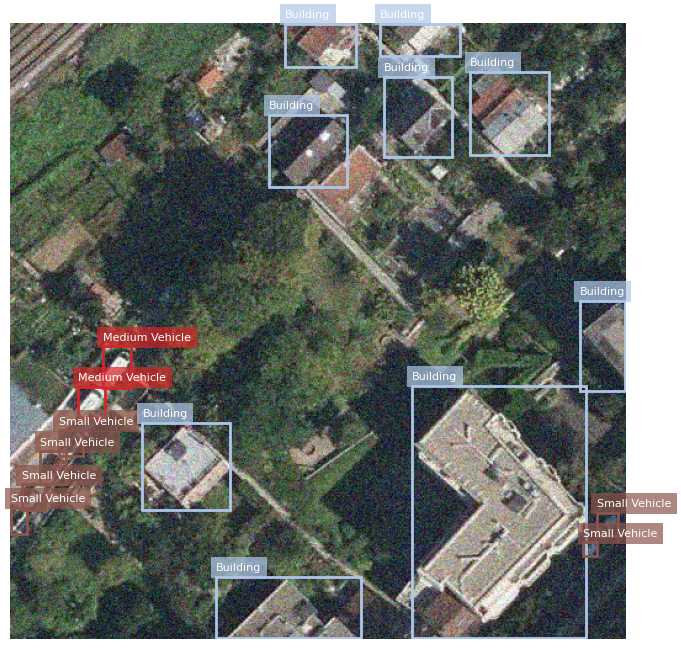

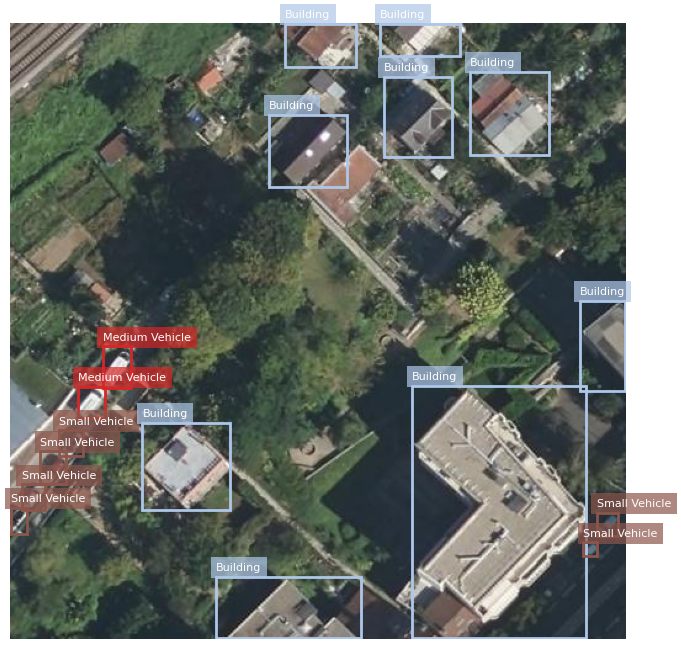

In [28]:
# img_aug est ton image numpy après augmentation
h, w = img_aug.shape[:2]
annotations_aug = yolo_boxes_to_annotations(boxes_aug, w, h)

plot_image_with_annotations(img_aug, annotations_aug, class_names=CADOT_CLASS_NAMES)
plot_image_with_annotations(img, annotations, class_names=CADOT_CLASS_NAMES)